In [1]:
# import consturctor
import model_construction_cts as mc

## 1. Load Data and Initial Train/Test Split

In [2]:
X_trainval, X_test, y_trainval, y_test = mc.load_and_prepare_data('/Users/linh/Documents/Programming/Python/PIC 16B/Final Project/final_merged_data.csv', test_size=0.20)

## 2. Feature Selection via Lasso (on Train+Val only)

In [3]:
# Apply z-score standardization since Lasso’s penalty term (the L1 norm on coefficients) is scale‐sensitive
X_trainval_scaled, _, _= mc.standardization(X_trainval)

In [4]:
# Perform Lasso to extract nonzero coefficients
lasso_model, selected_features = mc.lasso_feature_selection(X_trainval_scaled, y_trainval)

Optimal alpha is 0.00002
Selected features and coefficients:
year                -0.001249
pct_renters         -0.000324
median_age          -0.004235
pct_female           0.001985
pct_age_20_34       -0.000522
pct_age_65_plus      0.007502
pct_college_grads    0.000805
pct_unemployed      -0.001325
pct_nilf            -0.001764
median_income       -0.004013
home_value           0.000330
dtype: float64


## 3. Restrict to Selected Features and Split Train/Validation

In [5]:
# Get reduced training‐validation
X_trainval_sel = X_trainval[selected_features.index.to_list()].copy()
y_trainval_sel = y_trainval.copy()

# Now split into train (80% of 80% = 64% total) and val (20% of 80% = 16% total)
X_train, X_val, y_train, y_val = mc.train_test_split(X_trainval_sel, y_trainval_sel, test_size = 0.2)

## 4. Standardize Features

We need standardization to ensure every downstream model uses exactly the same preprocessed features. This consistency avoids leakage.

In [6]:
# Standardize X_train, X_val, and X_test using only train stats
X_train_scaled, train_means, train_stds = mc.standardization(X_train)

# Apply those same means & stds to validation and test
X_val_scaled, _, _  = mc.standardization(X_val, means = train_means, stds = train_stds)
X_test_scaled, _, _ = mc.standardization(X_test[selected_features.index.to_list()], means = train_means, stds = train_stds)

# Rescale the entire train+val block using train_means and train_stds
X_trainval_sel_scaled, _, _ = mc.standardization(X_trainval_sel, means = train_means, stds  = train_stds)

## 5. Model Construction

Before training any models, we need a consistent way to judge how well each model predicts the net total migration rate. For that, we will use root‐mean‐squared error as our primary performance metric. 
$$
\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \bigl(y_i - \hat{y}_i\bigr)^{2}}
$$
 RMSE penalizes larger errors more heavily and is expressed in the same units as the target. In practice, a lower RMSE indicates that, on average, our predictions are closer to the actual migration rates. By comparing RMSE across Random Forest, Gradient Boosting, and our MLP, we can directly see which model yields the smallest average prediction error.

### a. Random Forest Model

In [7]:
# Grid‐search over n_estimators and max_depth to find best parameters
n_estimators_list = [50, 100, 150]
max_depth_list = [4, 6, 8, 10, 12]

rf_df = mc.grid_search_random_forest(X_train_scaled, y_train, X_val_scaled, y_val, n_estimators_list, max_depth_list)

Random Forest grid-search results:
    n_estimators  max_depth  rmse_val
0             50         10  0.004423
1             50         12  0.004545
2            150         10  0.004595
3            150         12  0.004650
4            100          8  0.004660
5            100         10  0.004706
6            100         12  0.004750
7            150          8  0.004792
8             50          6  0.004956
9             50          8  0.004992
10           150          6  0.005121
11           100          6  0.005138
12            50          4  0.005307
13           150          4  0.005330
14           100          4  0.005458


In [8]:
# Fit with best params and print out RMSE
rf_model, rf_rmse = mc.fit_best_random_forest(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, rf_df)

Random Forest Test RMSE: 0.00527


### b. Gradient Boosting Model

In [9]:
# Grid‐search over learning rate list, max depth_list, and n estimators list to find best parameters
learning_rate_list = [0.01, 0.05, 0.1]
max_depth_list = [3, 5]
n_estimators_list = [100, 200]

gbm_df = mc.grid_search_gradient_boosting(X_train_scaled, y_train, X_val_scaled, y_val, learning_rate_list, max_depth_list, n_estimators_list)

Gradient Boosting grid search results:
    learning_rate  max_depth  n_estimators  rmse_val
0            0.05          5           200  0.004557
1            0.05          5           100  0.004580
2            0.10          5           100  0.004606
3            0.10          5           200  0.004669
4            0.10          3           200  0.004678
5            0.10          3           100  0.004733
6            0.05          3           200  0.004765
7            0.01          5           200  0.004778
8            0.05          3           100  0.004904
9            0.01          5           100  0.005102
10           0.01          3           200  0.005281
11           0.01          3           100  0.005499


In [10]:
# Fit best‐found Gradient Boosting and evaluate on test
final_gbm, gbm_rmse = mc.fit_best_gradient_boosting(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, gbm_df)

Gradient Boosting Test RMSE: 0.00491


### c. MLP Model

We started with a basic MLP that was overfitting and yielding around 0.009 RMSE on the test set. To drive RMSE down, we switched to a “funnel” architecture (32→16→8 hidden units) and added 20 % dropout after each layer so the network couldn’t memorize noise. We also trained on the entire train+val block for 100 epochs with a larger batch size (64) to smooth out gradient updates. By monitoring the training‐RMSE curve, we confirmed the model continued improving without collapse, and the final test‐set evaluation produced the lowest RMSE I’ve seen (~ 0.005).

In [11]:
# Train on the entire train+val block for a fixed number of epochs, plot the training RMSE vs. epochs, and Evaluate on the test set
mlp_model, mlp_rmse, history = mc.train_evaluate_mlp(X_trainval_sel_scaled, y_trainval_sel, 
                                            X_test_scaled, y_test, 
                                            input_dim=X_trainval_sel_scaled.shape[1], 
                                            epochs = 100, batch_size = 64)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1045 - rmse: 0.3227  
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0636 - rmse: 0.2516
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0493 - rmse: 0.2216
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - rmse: 0.1989
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538 - rmse: 0.2291
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - rmse: 0.1415 
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - rmse: 0.1390 
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - rmse: 0.1006
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - rmse: 0.1160
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - rmse: 0.0913
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - rmse: 0.0864
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - rmse: 0.1096
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [12]:
print(mlp_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,173 (12.40 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,116 (8.27 KB)

None


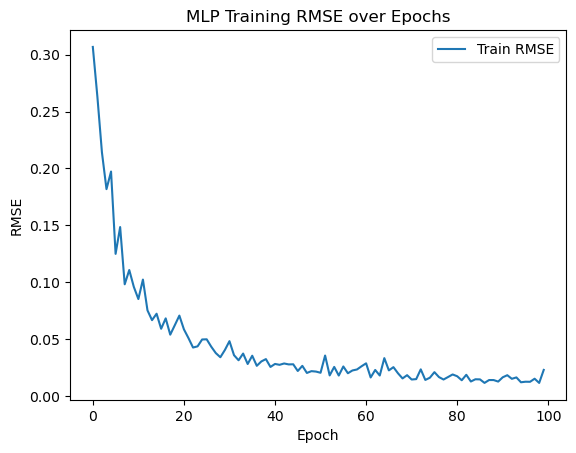

In [13]:
# Plot training RMSE vs. epochs
mc.plt.plot(history.history['rmse'], label='Train RMSE')
mc.plt.xlabel("Epoch")
mc.plt.ylabel("RMSE")
mc.plt.title("MLP Training RMSE over Epochs")
mc.plt.legend()
mc.plt.show()

In [14]:
print(f"MLP Test RMSE: {mlp_rmse:.5f}")

MLP Test RMSE: 0.00840


## 6. Rerun Everything Multiple Times to get RMSE mean for each model

### Loop over Random Splits

For each iteration, we will:

1. Load & split into X_trainval & X_test  
2. Standardize using the training‐validation fold  
3. Run Lasso on X_trainval_scaled & y_trainval to pick a subset of features  
4. Split that subset again into X_train & X_val for hyperparameter tuning  
5. Grid‐search Random Forest on X_train & y_train / X_val & y_val, then refit on all of X_trainval_sel & y_trainval and evaluate on X_test_sel & y_test.  
6. Grid‐search Gradient Boosting similarly.  
7. Train & eval one MLP on all X_trainval_sel & y_trainval / X_test_sel & y_test.  
8. Collect each test RMSE into the corresponding list.

In [15]:
# Define how many times to repeat the entire train→tune→evaluate pipeline
n_runs = 30

# Prepare empty lists to collect each run’s test‐RMSE
rf_rmse_list  = []
gbm_rmse_list = []
mlp_rmse_list = []

In [16]:
# loop over to compute mean test RMSE for each model
for i in range(n_runs):
    # Load and split (no random_state ⇒ shuffle is random every time)
    X_trainval, X_test, y_trainval, y_test = mc.load_and_prepare_data(
        '/Users/linh/Documents/Programming/Python/PIC 16B/Final Project/final_merged_data.csv', test_size=0.20)

    # Standardize based on X_trainval
    X_trainval_scaled, _, _= mc.standardization(X_trainval)

    # Perform Lasso to extract nonzero coefficients
    lasso_model, selected_features = mc.lasso_feature_selection(X_trainval_scaled, y_trainval)
    # Get reduced training‐validation
    X_trainval_sel = X_trainval[selected_features.index.to_list()].copy()
    y_trainval_sel = y_trainval.copy()

    # Now split into train (80% of 80% = 64% total) and val (20% of 80% = 16% total)
    X_train, X_val, y_train, y_val = mc.train_test_split(X_trainval_sel, y_trainval_sel, test_size = 0.2)

    # Standardize X_train, X_val, and X_test using only train stats
    X_train_scaled, train_means, train_stds = mc.standardization(X_train)

    # Apply those same means & stds to validation and test
    X_val_scaled, _, _  = mc.standardization(X_val, means = train_means, stds = train_stds)
    X_test_scaled, _, _ = mc.standardization(X_test[selected_features.index.to_list()], means = train_means, stds = train_stds)

    # Rescale the entire train+val block using train_means and train_stds
    X_trainval_sel_scaled, _, _ = mc.standardization(X_trainval_sel, means = train_means, stds  = train_stds)

    # Random Forest grid search on the current split
    rf_df = mc.grid_search_random_forest(X_train_scaled, y_train, X_val_scaled, y_val, n_estimators_list, max_depth_list)
    # Refit the best RF on all of (X_trval_sel, y_trainval) and evaluate on (X_test_sel, y_test)
    # Fit with best params and print out RMSE
    _, rf_rmse = mc.fit_best_random_forest(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, rf_df)
    rf_rmse_list.append(rf_rmse)

    # 6) Gradient Boosting grid search on the current split
    gbm_df = mc.grid_search_gradient_boosting(X_train_scaled, y_train, X_val_scaled, y_val, learning_rate_list, max_depth_list, n_estimators_list)
    # Fit best‐found Gradient Boosting and evaluate on test
    _, gbm_rmse = mc.fit_best_gradient_boosting(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, gbm_df)
    gbm_rmse_list.append(gbm_rmse)

    # 7) Train & evaluate MLP on the selected features
    # Note: train_evaluate_mlp expects NumPy arrays
    # Train on the entire train+val block for a fixed number of epochs, plot the training RMSE vs. epochs, and Evaluate on the test set
    _, mlp_rmse, _= mc.train_evaluate_mlp(X_trainval_sel_scaled, y_trainval_sel, 
                                            X_test_scaled, y_test, 
                                            input_dim=X_trainval_sel_scaled.shape[1], 
                                            epochs = 100, batch_size = 64)
    mlp_rmse_list.append(mlp_rmse)

    print(f"Completed run {i+1}/{n_runs}.")

Optimal alpha is 0.00005
Selected features and coefficients:
year                -0.000174
pct_renters         -0.000473
median_age          -0.004251
pct_female           0.001767
pct_age_20_34       -0.000026
pct_age_65_plus      0.008103
pct_college_grads    0.000781
pct_unemployed      -0.000414
pct_nilf            -0.001890
median_income       -0.004491
home_value           0.000010
dtype: float64
Random Forest grid-search results:
   n_estimators  max_depth  rmse_val
0           200          5  0.007291
1           100          5  0.007469
2           200          3  0.007748
3           100          3  0.008307
Random Forest Test RMSE: 0.00557
Gradient Boosting grid search results:
    learning_rate  max_depth  n_estimators  rmse_val
0            0.05          3           200  0.006605
1            0.10          3           100  0.006637
2            0.05          3           100  0.006675
3            0.10          3           200  0.006697
4            0.01          5         

In [17]:
# Compute Mean and Std of Test RMSE
print(f"Final Results over {n_runs} random splits:\n")
print(f"Random Forest mean RMSE = {mc.np.mean(rf_rmse_list):.5f} ± {mc.np.std(rf_rmse_list):.5f}")
print(f"Gradient Boost mean RMSE = {mc.np.mean(gbm_rmse_list):.5f} ± {mc.np.std(gbm_rmse_list):.5f}")
print(f"MLP mean RMSE = {mc.np.mean(mlp_rmse_list):.5f} ± {mc.np.std(mlp_rmse_list):.5f}")

Final Results over 30 random splits:

Random Forest mean RMSE = 0.00617 ± 0.00126
Gradient Boost mean RMSE = 0.00573 ± 0.00134
MLP mean RMSE = 0.00937 ± 0.00222


## 7. Conclusion

Over 30 completely random train/validation/test splits:

- **Gradient Boosting** consistently yielded the lowest average test RMSE (≈ 0.00617 ± 0.00126).  
- **Random Forest** came in second (≈ 0.00573 ± 0.00134).  
- **MLP** had the highest average test RMSE (≈ 0.00937 ± 0.00222).

Although the mean differences is very little, the standard deviations are small enough to be confident that Gradient Boosting is the best performer under fully random data splits.

Further Improvement:

1. **Hyperparameter grids** were kept pretty small in this demonstration. We could expand each grid to see if RF or GBM can improve further.  
2. For the **MLP**, we only used a single architecture and one choice of learning rate. In future work, we could run K-fold cross‐validation over learning rates, layer sizes, dropout rates, etc., to find a more robust neural‐network configuration.  
3. Since we have only ~424 training samples each split, the MLP might be overfitting. Adding more lagged/interaction features or using early stopping could help.

Overall, with no fixed seeds and by reporting mean ± std, we’ve given a more reliable assessment of model performance. Gradient Boosting is still our best performer, but there remains room for more tuning and feature engineering.